In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 

In [2]:
import scipy.stats as stats
from collections import defaultdict
from scipy.stats.stats import pearsonr

In [3]:
import csv

In [4]:
import seaborn as sns

In [5]:
import plotly.express as px

In [6]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram

## Preprocessing

In [7]:
df = pd.read_csv('github_aggregate.csv', index_col=False, on_bad_lines='skip')

In [8]:
df.drop(columns = 'Unnamed: 0', axis=1, inplace=True)

In [9]:
col = ['n_of_pr_comments', 'n_of_followers', 'n_of_commits', 'n_of_commit_comments', 'n_of_issue_comments']

In [10]:
df.head()

,user_id,n_of_pr_comments,n_of_followers,n_of_commits,n_of_commit_comments,n_of_issue_comments
0,0,11.0,NaN,NaN,14.0,NaN
1,1,15.0,31.0,21.0,6.0,30.0
2,2,25.0,400.0,3598.0,25.0,1504.0
3,3,4.0,NaN,2.0,3.0,NaN
4,4,5.0,174.0,463.0,14.0,516.0


In [11]:
df.shape

(7141502, 6)

Drop users having less than 4 valid data (one of them is user_id which is always valid)

In [12]:
df = df.dropna(how='any',axis=0,thresh=5)

In [13]:
df.isna().sum()

user_id                     0
n_of_pr_comments        61715
n_of_followers            323
n_of_commits            16750
n_of_commit_comments     8249
n_of_issue_comments        42
dtype: int64

In [14]:
df.shape

(117841, 6)

In [15]:
df.head()

,user_id,n_of_pr_comments,n_of_followers,n_of_commits,n_of_commit_comments,n_of_issue_comments
1,1,15.0,31.0,21.0,6.0,30.0
2,2,25.0,400.0,3598.0,25.0,1504.0
4,4,5.0,174.0,463.0,14.0,516.0
5,5,62.0,390.0,1057.0,44.0,3103.0
6,6,5.0,8.0,5784.0,3.0,6.0


In [16]:
df[col].describe()

,n_of_pr_comments,n_of_followers,n_of_commits,n_of_commit_comments,n_of_issue_comments
count,56126.000000,117518.000000,101091.000000,109592.000000,117799.000000
mean,32.409097,79.455386,113.063299,18.770157,457.980501
std,194.088859,524.014436,316.786688,86.995440,1425.421577
min,1.000000,1.000000,1.000000,0.000000,1.000000
25%,2.000000,8.000000,6.000000,1.000000,29.000000
50%,4.000000,21.000000,27.000000,4.000000,98.000000
75%,14.000000,51.000000,102.000000,12.000000,332.000000
max,30699.000000,53972.000000,25403.000000,7856.000000,93509.000000


Deleting missing values and infinity for cluster analysis

In [17]:
# checking for infinity https://www.geeksforgeeks.org/check-if-dataframe-contains-infinity-in-python-pandas/
ds = df.isin([np.inf, -np.inf])  

In [18]:
# count infinity
count = np.isinf(df).values.sum()

In [19]:
print(count)  

0


### Fill all missing values

In [20]:
df['n_of_issue_comments'].interpolate(method='linear', limit_direction='forward', downcast='infer', inplace=True)
df['n_of_followers'].interpolate(method='linear', limit_direction='forward', downcast='infer', inplace=True)
df['n_of_commits'].fillna(method="ffill", downcast='infer', inplace=True) 
df['n_of_pr_comments'].fillna(method="ffill", downcast='infer', inplace=True) 
df['n_of_commit_comments'].interpolate(method='linear', limit_direction='forward', downcast='infer', inplace=True)

In [21]:
df.isna().sum()

user_id                 0
n_of_pr_comments        0
n_of_followers          0
n_of_commits            0
n_of_commit_comments    0
n_of_issue_comments     0
dtype: int64

In [22]:
df.head()

,user_id,n_of_pr_comments,n_of_followers,n_of_commits,n_of_commit_comments,n_of_issue_comments
1,1,15,31.0,21,6.0,30.0
2,2,25,400.0,3598,25.0,1504.0
4,4,5,174.0,463,14.0,516.0
5,5,62,390.0,1057,44.0,3103.0
6,6,5,8.0,5784,3.0,6.0


In [23]:
df[col].describe()

,n_of_pr_comments,n_of_followers,n_of_commits,n_of_commit_comments,n_of_issue_comments
count,117841.000000,117841.000000,117841.000000,117841.000000,117841.000000
mean,15.959708,79.431709,99.818976,19.673785,457.991192
std,134.862269,523.679942,297.652154,91.044208,1425.221504
min,1.000000,1.000000,1.000000,0.000000,1.000000
25%,1.000000,8.000000,3.000000,2.000000,29.000000
50%,1.000000,21.000000,19.000000,4.000000,98.000000
75%,4.000000,51.000000,86.000000,13.000000,332.000000
max,30699.000000,53972.000000,25403.000000,7856.000000,93509.000000


In [24]:
df.dtypes

user_id                   int64
n_of_pr_comments          int64
n_of_followers          float64
n_of_commits              int64
n_of_commit_comments    float64
n_of_issue_comments     float64
dtype: object

#### Scale before discretize

In [25]:
col = ['n_of_pr_comments', 'n_of_followers', 'n_of_commits', 'n_of_commit_comments', 'n_of_issue_comments']

In [26]:
df_copy = df.copy()

In [27]:
features = df_copy[col]

In [28]:
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)

In [29]:
df_copy[col] = features

In [30]:
pd.set_option('display.float_format', '{:.1e}'.format)

In [31]:
df_copy[col].describe()


,n_of_pr_comments,n_of_followers,n_of_commits,n_of_commit_comments,n_of_issue_comments
count,1.2e+05,1.2e+05,1.2e+05,1.2e+05,1.2e+05
mean,4.9e-04,1.5e-03,3.9e-03,2.5e-03,4.9e-03
std,4.4e-03,9.7e-03,1.2e-02,1.2e-02,1.5e-02
min,0.0e+00,0.0e+00,0.0e+00,0.0e+00,0.0e+00
25%,0.0e+00,1.3e-04,7.9e-05,2.5e-04,3.0e-04
50%,0.0e+00,3.7e-04,7.1e-04,5.1e-04,1.0e-03
75%,9.8e-05,9.3e-04,3.3e-03,1.7e-03,3.5e-03
max,1.0e+00,1.0e+00,1.0e+00,1.0e+00,1.0e+00


In [32]:
df_copy.shape

(117841, 6)

In [33]:
df_copy.head()

,user_id,n_of_pr_comments,n_of_followers,n_of_commits,n_of_commit_comments,n_of_issue_comments
1,1,4.6e-04,5.6e-04,7.9e-04,7.6e-04,3.1e-04
2,2,7.8e-04,7.4e-03,1.4e-01,3.2e-03,1.6e-02
4,4,1.3e-04,3.2e-03,1.8e-02,1.8e-03,5.5e-03
5,5,2.0e-03,7.2e-03,4.2e-02,5.6e-03,3.3e-02
6,6,1.3e-04,1.3e-04,2.3e-01,3.8e-04,5.3e-05


In [34]:
df = df_copy.copy()

#### Discretize n of pr comments

In [35]:
df['n_of_pr_comments'].describe(percentiles=[0.60, 0.65, 0.75,.8,.85,.9,.95,.98,.99])

count   1.2e+05
mean    4.9e-04
std     4.4e-03
min     0.0e+00
50%     0.0e+00
60%     0.0e+00
65%     3.3e-05
75%     9.8e-05
80%     1.6e-04
85%     2.9e-04
90%     5.9e-04
95%     1.6e-03
98%     4.9e-03
99%     9.5e-03
max     1.0e+00
Name: n_of_pr_comments, dtype: float64

In [38]:
df_copy[col].describe(percentiles=[0.65, 0.75])
#df_copy[col].describe()

,n_of_pr_comments,n_of_followers,n_of_commits,n_of_commit_comments,n_of_issue_comments
count,1.2e+05,1.2e+05,1.2e+05,1.2e+05,1.2e+05
mean,4.9e-04,1.5e-03,3.9e-03,2.5e-03,4.9e-03
std,4.4e-03,9.7e-03,1.2e-02,1.2e-02,1.5e-02
min,0.0e+00,0.0e+00,0.0e+00,0.0e+00,0.0e+00
50%,0.0e+00,3.7e-04,7.1e-04,5.1e-04,1.0e-03
65%,3.3e-05,6.1e-04,1.8e-03,1.0e-03,2.1e-03
75%,9.8e-05,9.3e-04,3.3e-03,1.7e-03,3.5e-03
max,1.0e+00,1.0e+00,1.0e+00,1.0e+00,1.0e+00


In [50]:
df['pr_comments_cut'] = pd.cut(df['n_of_pr_comments'], 
                            bins=[df['n_of_pr_comments'].min(), np.percentile(df['n_of_pr_comments'], 65), df['n_of_pr_comments'].mean(), df['n_of_pr_comments'].max()], 
                            labels=['low', 'medium', 'high'],
                            include_lowest=True)

According to the distribution and statistics (and intuition as well)

In [51]:
df['pr_comments_cut'].value_counts()

low       83185
medium    21348
high      13308
Name: pr_comments_cut, dtype: int64

In [52]:
df['issue_comments_cut'] = pd.cut(df['n_of_issue_comments'], 
                            bins=[df['n_of_issue_comments'].min(), np.percentile(df['n_of_issue_comments'], 65), df['n_of_issue_comments'].mean(), df['n_of_issue_comments'].max()], 
                            labels=['low', 'medium', 'high'],
                                 include_lowest=True)

In [53]:
df['issue_comments_cut'].value_counts()

low       76614
high      23432
medium    17795
Name: issue_comments_cut, dtype: int64

In [54]:
df['commits_cut'] = pd.cut(df['n_of_commits'], 
                            bins=[df['n_of_commits'].min(), np.percentile(df['n_of_commits'], 65), df['n_of_commits'].mean(), df['n_of_commits'].max()], 
                            labels=['low', 'medium', 'high'],
                          include_lowest=True)

In [55]:
df['commits_cut'].value_counts()

low       76836
high      26468
medium    14537
Name: commits_cut, dtype: int64

In [56]:
df['commit_comments_cut'] = pd.cut(df['n_of_commit_comments'], 
                            bins=[0, np.percentile(df['n_of_commit_comments'], 65), df['n_of_commit_comments'].mean(), df['n_of_commit_comments'].max()], 
                            labels=['low', 'medium', 'high'],
                                  include_lowest=True)

In [57]:
df['commit_comments_cut'].value_counts()

low       78607
high      21451
medium    17783
Name: commit_comments_cut, dtype: int64

In [58]:
df['followers_cut'] = pd.cut(df['n_of_followers'], 
                            bins=[0, np.percentile(df['n_of_followers'], 65), df['n_of_followers'].mean(), df['n_of_followers'].max()], 
                            labels=['low', 'medium', 'high'],
                            include_lowest=True)

In [59]:
df['followers_cut'].value_counts()

low       76653
medium    21939
high      19249
Name: followers_cut, dtype: int64

In [60]:
col_cut = ['pr_comments_cut', 'commit_comments_cut', 'issue_comments_cut', 'commits_cut', 'followers_cut' ]

In [61]:
df[col_cut].isna().sum()

pr_comments_cut        0
commit_comments_cut    0
issue_comments_cut     0
commits_cut            0
followers_cut          0
dtype: int64

In [65]:
df.head()

,user_id,n_of_pr_comments,n_of_followers,n_of_commits,n_of_commit_comments,n_of_issue_comments,pr_comments_cut,issue_comments_cut,commits_cut,commit_comments_cut,followers_cut
1,1,4.6e-04,5.6e-04,7.9e-04,7.6e-04,3.1e-04,medium,low,low,low,low
2,2,7.8e-04,7.4e-03,1.4e-01,3.2e-03,1.6e-02,high,high,high,high,high
4,4,1.3e-04,3.2e-03,1.8e-02,1.8e-03,5.5e-03,medium,high,high,medium,high
5,5,2.0e-03,7.2e-03,4.2e-02,5.6e-03,3.3e-02,high,high,high,high,high
6,6,1.3e-04,1.3e-04,2.3e-01,3.8e-04,5.3e-05,medium,low,high,low,low


### Cluster analysis on the dataset of actions

### Kmeans

In [70]:
col_clust=df[['n_of_pr_comments', 'n_of_followers', 'n_of_commits', 'n_of_commit_comments', 'n_of_issue_comments']]
#Variables of interest for clustering

In [74]:
col_clust.head()

,n_of_pr_comments,n_of_followers,n_of_commits,n_of_commit_comments,n_of_issue_comments
1,4.6e-04,5.6e-04,7.9e-04,7.6e-04,3.1e-04
2,7.8e-04,7.4e-03,1.4e-01,3.2e-03,1.6e-02
4,1.3e-04,3.2e-03,1.8e-02,1.8e-03,5.5e-03
5,2.0e-03,7.2e-03,4.2e-02,5.6e-03,3.3e-02
6,1.3e-04,1.3e-04,2.3e-01,3.8e-04,5.3e-05


In [75]:
type(col_clust)

pandas.core.frame.DataFrame

In [76]:
cols = [col for col in col_clust.columns]
X = col_clust[cols].values


In [69]:
type(X_minmax)

numpy.ndarray

In [81]:
wcss = [] 
for i in range(1, 21): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X) 
    wcss.append(kmeans.inertia_)

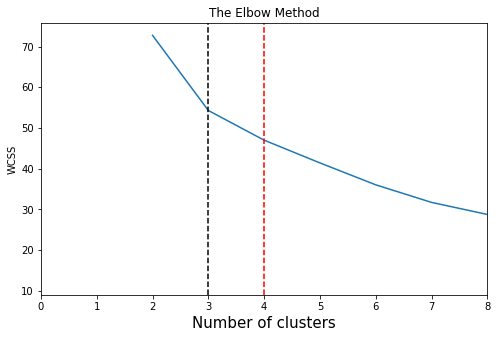

In [79]:

plt.figure(figsize=(8, 5))
plt.plot(range(2, len(wcss)+2), wcss)  # , xticks=range(6)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters', fontsize=15)
plt.ylabel('WCSS')
plt.axvline(x=3, color='k', linestyle='--')
plt.axvline(x=4, color='r', linestyle='--')
plt.xlim([0, 8])
plt.show()

In [82]:
kmeans = KMeans(n_clusters = 4, init = "k-means++", random_state = 42)
y_kmeans = kmeans.fit(X_minmax)

In [89]:
#print('SSE', kmeans.inertia_)
#print('Silhouette', silhouette_score(X_minmax, kmeans.labels_)) 

In [83]:
kmeans.cluster_centers_

centers = kmeans.cluster_centers_

centers = scaler.inverse_transform(centers)

In [84]:
print(kmeans.labels_)

[0 1 0 ... 0 0 0]


In [85]:
clust_name = ['0', '1', '2', '3']

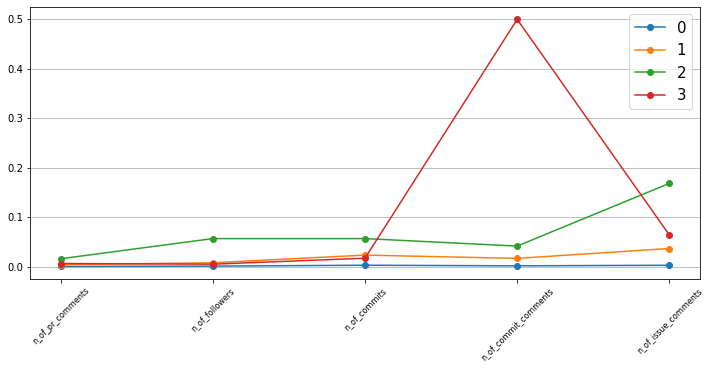

In [86]:
plt.figure(figsize=(12, 5))

clust_name = ['0', '1', '2', '3']
for i in range(len(centers)):
    plt.plot(centers[i], marker='o', label=clust_name[i])
    
plt.xticks(range(0, len(cols)), cols, fontsize=8, rotation=45)
plt.yticks(fontsize=10)


plt.legend(fontsize=15, loc='best')
plt.grid(axis='y')

In [87]:
df['kmeans_labels'] = kmeans.labels_

In [88]:
df.head(10)

,user_id,n_of_pr_comments,n_of_followers,n_of_commits,n_of_commit_comments,n_of_issue_comments,pr_comments_cut,issue_comments_cut,commits_cut,commit_comments_cut,followers_cut,kmeans_labels
1,1,4.6e-04,5.6e-04,7.9e-04,7.6e-04,3.1e-04,medium,low,low,low,low,0
2,2,7.8e-04,7.4e-03,1.4e-01,3.2e-03,1.6e-02,high,high,high,high,high,1
4,4,1.3e-04,3.2e-03,1.8e-02,1.8e-03,5.5e-03,medium,high,high,medium,high,0
5,5,2.0e-03,7.2e-03,4.2e-02,5.6e-03,3.3e-02,high,high,high,high,high,1
6,6,1.3e-04,1.3e-04,2.3e-01,3.8e-04,5.3e-05,medium,low,high,low,low,1
7,8,3.3e-05,1.9e-04,0.0e+00,1.3e-04,0.0e+00,low,low,low,low,low,0
8,9,0.0e+00,9.8e-04,2.2e-02,3.8e-04,1.7e-03,low,low,high,low,medium,0
9,10,1.8e-03,4.9e-02,1.2e-02,1.8e-02,1.9e-01,high,high,high,high,high,2
10,11,0.0e+00,7.4e-05,1.6e-03,3.8e-04,2.0e-03,low,low,low,low,low,0
11,12,1.6e-04,4.6e-04,7.5e-03,1.7e-03,1.4e-03,medium,low,high,medium,low,0


In [89]:
df.dtypes

user_id                    int64
n_of_pr_comments         float64
n_of_followers           float64
n_of_commits             float64
n_of_commit_comments     float64
n_of_issue_comments      float64
pr_comments_cut         category
issue_comments_cut      category
commits_cut             category
commit_comments_cut     category
followers_cut           category
kmeans_labels              int32
dtype: object

### Plot

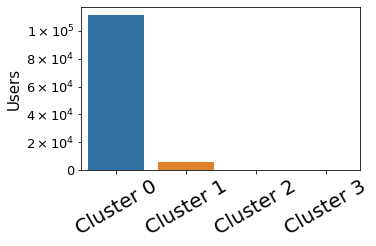

In [90]:
plt.figure(figsize=(5, 3))
sns.countplot(data=df, x='kmeans_labels')
plt.ylabel('Users', fontsize=15)
plt.xlabel('', fontsize=16)
plt.yticks(ticks=[0, 20000, 40000, 60000, 80000, 100000], labels=['0', r'$2 \times 10^4$', r'$4 \times 10^4$', r'$6 \times 10^4$', r'$8 \times 10^4$', r'$1 \times 10^5$'], fontsize=13)

plt.xticks(ticks=[0, 1, 2, 3], labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], fontsize=20, rotation=30)

plt.show()




#################


In [91]:
df['kmeans_labels'].value_counts()

0    111512
1      5887
2       415
3        27
Name: kmeans_labels, dtype: int64

The first cluster is the one with low active users: it is interesting to note that the n of commits it is medium for this cluster, meaning that the "basic" activity of modifying bugs/errors on Github is conducted also by this type of users. Therefore being active regards more other kind of activities

In [92]:
print(col)

['n_of_pr_comments', 'n_of_followers', 'n_of_commits', 'n_of_commit_comments', 'n_of_issue_comments']


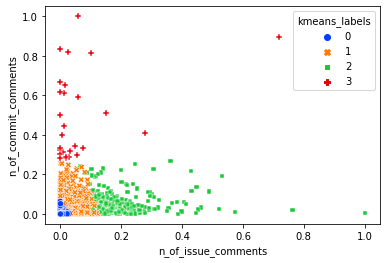

In [93]:
sns.scatterplot(data=df, x="n_of_issue_comments", y="n_of_commit_comments", hue="kmeans_labels", style="kmeans_labels",
                palette="bright")
plt.show()

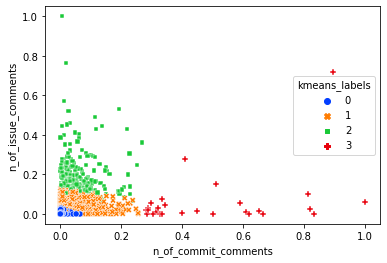

In [94]:
sns.scatterplot(data=df, x="n_of_commit_comments", y="n_of_issue_comments", hue="kmeans_labels", style="kmeans_labels",
                palette="bright")
plt.show()

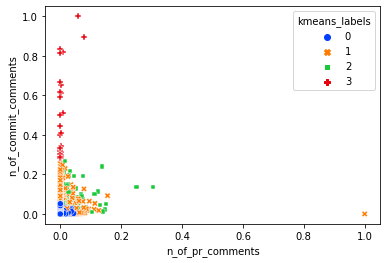

In [97]:
sns.scatterplot(data=df, x="n_of_pr_comments", y="n_of_commit_comments", hue="kmeans_labels", style="kmeans_labels",
                palette="bright")
plt.show()

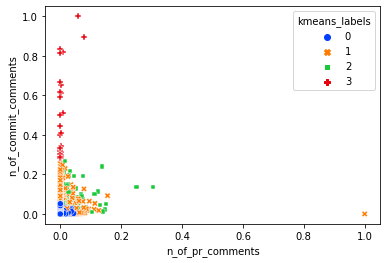

In [98]:
sns.scatterplot(data=df, x="n_of_pr_comments", y="n_of_commit_comments", hue="kmeans_labels", style="kmeans_labels",
                palette="bright")
plt.show()

In [99]:
col_cut

['pr_comments_cut',
 'commit_comments_cut',
 'issue_comments_cut',
 'commits_cut',
 'followers_cut']

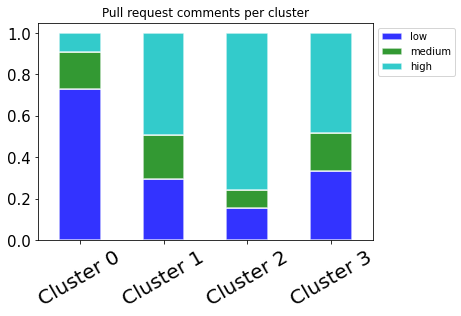

In [100]:
bar_pl = df['pr_comments_cut'].groupby(df['kmeans_labels']).value_counts(normalize=True).unstack(1)
bar_pl.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5, title='Pull request comments per cluster', color=['b', 'g', 'c'])

plt.xlabel('', fontsize=16)
plt.xticks(range(0, len(clust_name)), labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], fontsize=20, rotation=30)
plt.yticks(fontsize=15)
plt.legend(bbox_to_anchor=(1,1))

plt.show()

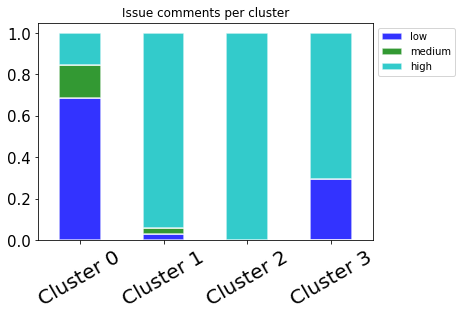

In [101]:
bar_pl = df['issue_comments_cut'].groupby(df['kmeans_labels']).value_counts(normalize=True).unstack(1)
bar_pl.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5, title='Issue comments per cluster', color=['b', 'g', 'c'])

plt.xlabel('', fontsize=16)
#plt.xticks(ticks=[0, 1, 2, 3], labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], fontsize=16)
plt.xticks(range(0, len(clust_name)), labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], fontsize=20, rotation=30)
plt.yticks(fontsize=15)
plt.legend(bbox_to_anchor=(1,1))

plt.show()

This variable is interesting because it discriminates first from others

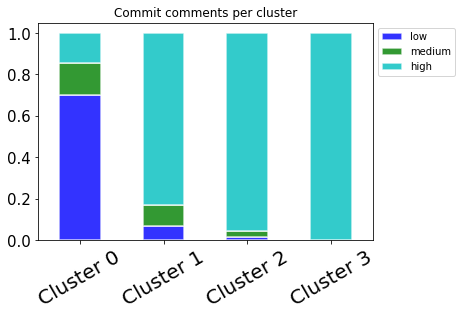

In [102]:
bar_pl = df['commit_comments_cut'].groupby(df['kmeans_labels']).value_counts(normalize=True).unstack(1)
bar_pl.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5, title='Commit comments per cluster', color=['b', 'g', 'c'])

plt.xlabel('', fontsize=16)
#plt.xticks(ticks=[0, 1, 2, 3], labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], fontsize=16)
plt.xticks(range(0, len(clust_name)), labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], fontsize=20, rotation=30)
plt.yticks(fontsize=15)
plt.legend(bbox_to_anchor=(1,1))

plt.show()

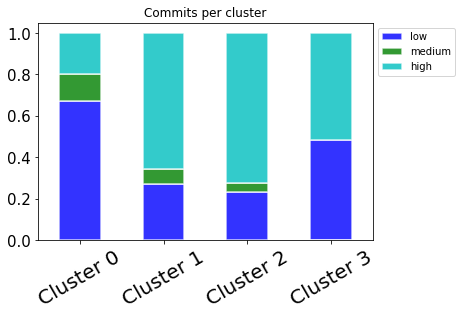

In [103]:
bar_pl = df['commits_cut'].groupby(df['kmeans_labels']).value_counts(normalize=True).unstack(1)
bar_pl.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5, title='Commits per cluster', color=['b', 'g', 'c'])

plt.xlabel('', fontsize=16)
#plt.xticks(ticks=[0, 1, 2, 3], labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], fontsize=16)
plt.xticks(range(0, len(clust_name)), labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], fontsize=20, rotation=30)
plt.yticks(fontsize=15)
plt.legend(bbox_to_anchor=(1,1))

plt.show()

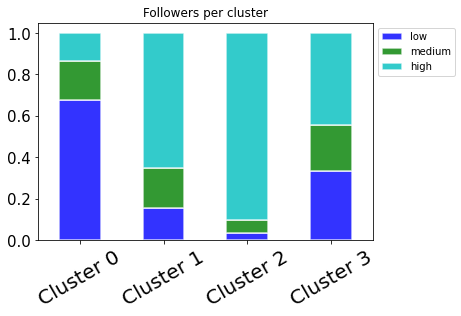

In [104]:
bar_pl = df['followers_cut'].groupby(df['kmeans_labels']).value_counts(normalize=True).unstack(1)
bar_pl.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5, title='Followers per cluster', color=['b', 'g', 'c'])

plt.xlabel('', fontsize=16)
#plt.xticks(ticks=[0, 1, 2, 3], labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], fontsize=16)
plt.xticks(range(0, len(clust_name)), labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], fontsize=20, rotation=30)
plt.yticks(fontsize=15)
plt.legend(bbox_to_anchor=(1,1))

plt.show()

Cluster A is probably the least interesting for us

In [105]:
df_active = df.copy()

In [106]:
df_active.sort_values(by='kmeans_labels').head(20)

,user_id,n_of_pr_comments,n_of_followers,n_of_commits,n_of_commit_comments,n_of_issue_comments,pr_comments_cut,issue_comments_cut,commits_cut,commit_comments_cut,followers_cut,kmeans_labels
1,1,4.6e-04,5.6e-04,7.9e-04,7.6e-04,3.1e-04,medium,low,low,low,low,0
240653,145874,0.0e+00,4.4e-04,3.8e-03,1.3e-04,2.7e-04,low,low,medium,low,low,0
240651,145868,0.0e+00,6.2e-03,1.2e-03,3.8e-04,4.2e-03,low,medium,low,low,high,0
240650,145866,0.0e+00,8.5e-04,2.0e-03,8.9e-04,1.9e-02,low,high,medium,low,medium,0
240647,145861,0.0e+00,1.1e-03,2.0e-03,1.1e-03,7.3e-03,low,high,medium,medium,medium,0
240640,145850,0.0e+00,4.8e-04,5.9e-04,7.6e-04,2.7e-03,low,medium,low,low,low,0
240638,145848,0.0e+00,5.2e-04,5.1e-04,1.3e-04,3.3e-03,low,medium,low,low,low,0
240634,145842,0.0e+00,2.6e-04,5.1e-04,2.5e-04,6.6e-04,low,low,low,low,low,0
240633,145841,0.0e+00,1.4e-03,1.6e-04,2.5e-04,4.8e-03,low,medium,low,low,medium,0
240630,145838,0.0e+00,1.7e-04,2.0e-04,3.8e-04,9.6e-05,low,low,low,low,low,0


In [107]:
df_active = df_active[df['kmeans_labels'] != 0]

In [108]:
df_active.sort_values(by='kmeans_labels').head()

,user_id,n_of_pr_comments,n_of_followers,n_of_commits,n_of_commit_comments,n_of_issue_comments,pr_comments_cut,issue_comments_cut,commits_cut,commit_comments_cut,followers_cut,kmeans_labels
2,2,7.8e-04,7.4e-03,1.4e-01,3.2e-03,1.6e-02,high,high,high,high,high,1
37576,452259,1.0e-02,2.6e-04,7.8e-03,1.5e-02,4.6e-02,high,high,high,high,low,1
37506,450543,1.4e-03,4.6e-04,1.2e-04,6.9e-03,3.3e-02,high,high,low,high,low,1
37412,448274,6.2e-04,4.9e-02,4.1e-03,3.9e-03,3.0e-02,high,high,high,high,high,1
37381,447669,0.0e+00,8.2e-04,0.0e+00,2.9e-02,3.6e-02,low,high,low,high,medium,1


In [109]:
df_active.shape

(6329, 12)

In [110]:
df_active.to_csv('active_users.csv', index=False)

In [115]:
df_active.head()

,user_id,n_of_pr_comments,n_of_followers,n_of_commits,n_of_commit_comments,n_of_issue_comments,pr_comments_cut,issue_comments_cut,commits_cut,commit_comments_cut,followers_cut,kmeans_labels
2,2,7.8e-04,7.4e-03,1.4e-01,3.2e-03,1.6e-02,high,high,high,high,high,1
5,5,2.0e-03,7.2e-03,4.2e-02,5.6e-03,3.3e-02,high,high,high,high,high,1
6,6,1.3e-04,1.3e-04,2.3e-01,3.8e-04,5.3e-05,medium,low,high,low,low,1
9,10,1.8e-03,4.9e-02,1.2e-02,1.8e-02,1.9e-01,high,high,high,high,high,2
15,24,3.3e-05,1.4e-03,1.4e-02,6.4e-04,2.4e-02,low,high,high,low,medium,1


In [120]:
df_active_user = df_active[['user_id']]

In [121]:
df_active_user.head()

,user_id
2,2
5,5
6,6
9,10
15,24


In [122]:
#df_active_user.to_csv('C:/Users/costa/Onedrive/Desktop/GITHUB/Processed/active_users_id.csv', index=False)

In [123]:
df_active.dtypes

user_id                    int64
n_of_pr_comments         float64
n_of_followers           float64
n_of_commits             float64
n_of_commit_comments     float64
n_of_issue_comments      float64
pr_comments_cut         category
issue_comments_cut      category
commits_cut             category
commit_comments_cut     category
followers_cut           category
kmeans_labels              int32
dtype: object

# TO DO: clean the file and add a line to merge this active user with users in general

In [125]:
# MERGE WITH USERS TABLE IN GENERAL